<a href="https://colab.research.google.com/github/zuzannazak/PhD2022Bialowieza/blob/main/%F0%9F%92%96projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Study on orthodox population in Białowieża 1878-2020***




**Authors:**

Wiktoria Rakowska

Monika Wesołowska

Zuzanna Żak


**Data:**
*   Aggregated in https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_aggregated.xls?raw=true :
  *   Chrzty, śluby i zgony w parafii prawosłwanej św. Mikołaja Cudotwórcy w Białowieży https://github.com/pbiecek/SmarterPoland_blog/tree/master/dane/Bialowieza/
  *   Population data for Białowieża, rural gmina, from Bank Danych Lokalnych
  *   Population data for Poland https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/struktura-ludnosci,16,1.html 
  *   Religious practices in Poland https://cbos.pl/SPISKOM.POL/2020/K_063_20.PDF 

# ***introduction***

Many developed countries (Germany, Spain, Czech Republic, USA, Japan etc.) struggle with demographic and social problems, including a decline in fertility (Baranowska, 2017), decreased religiosity, or reluctance to marry.

The aging population is common and completely normal. The problem arises when this phenomenon occurs quickly and on a large scale. The simultaneous decline in mortality and the decreasing fertility rate may lead to severe social, economic, and cultural consequences (Tomaszek, 2020). There were 703 million persons aged 65 years or over in the world in 2019. The number of older persons is predicted to double to 1.5 billion in 2050. Globally, the share of the population aged 65 years or over increased from 6% in 1990 to 9% in 2019 (United Nations,2019).  Polish society has also been aging since the 1990s, mainly manifested by an increase in the number of people in post-productive age and a decrease in the number of people in pre-productive age. In 2010, people aged 65 or over accounted for 16.8% of the total Polish population, while it is estimated that in 2035 this number will increase to approx. 27% (Ciura, Szymańczak, 2012).

The second observed trend is the community's decline in religiosity and religious practices. According to S. Bullivant, a professor of theology and the sociology of religion at St Mary’s University in London “With some notable exceptions, young adults increasingly are not identifying with or practicing religion" (Gray,2018). This phenomenon is spreading more or less all over Europe.A breakdown in faith is also observed in Poland. Every year the number of people practicing regularly decreased in 1997-2007; this percentage was about 58% -59%, in 2013-2018, about 49% -50% (CBOS, 2020).

The decline in religiosity results in a decrease in religious marriages. According to the GUS (2019), the number of religious marriages in Poland decreases every year. In 2000, their number was 151 thousand. 757, and in 2010 - 155 thousand. 509, while in 2018, only 119 thousand. 74 marriages. There is a global decline in marriages, both civil and religious. Since 1964 the marriage rate in the EU has decreased in relative terms by nearly 50% (from 8.0 per 1000 people in 1964 to 4.3 in 2019) (Eurostat,2021). As a result, a decline in marriages harms the fertility rate. 

The trends mentioned above may significantly affect the data of baptisms, funerals, and weddings in Białowieża.





# ***history and description of the city of Białowieża***

Białowieża is a small town (203.1 km2, about 2 000 inhabitants) located in the Podlaskie Voivodeship on the edge of the Białowieża National Park, a unique region of Poland entered on the UNESCO list. The town is situated right on the border with Belarus and is a famous travel destination for domestic and foreign tourists.

Initially, Białowieża was a hunting place for Polish kings who claimed the right to the game there. For many centuries, such crowned heads as Kazimierz Jagiellończyk, Stefan Batory, August II Mocny, August III Sas and Stanisław August Poniatowski hunted in the Białowieża Forest.

Białowieża witnessed many bloody events related to both wars and national and liberation uprisings. As a result of the third partition of Poland, Białowieża was annexed to Russia. In 1807 it became part of the Duchy of Warsaw, and then in 1815, Poland's Kingdom. The greatest development of the settlement took place at the turn of the 18th and 19th centuries; however, the intensification of hunting and felling of trees contributed to the significant destruction of the Białowieża Forest. In 1919, after the period of Russian and German occupation, Białowieża was within the borders of Poland, and its reconstruction began and ended in 1923. Bialowieża was also damaged during World War II, during which many of the city's inhabitants lost their lives (StayPoland,2022).

Currently, Białowieża is one of the most popular tourist centers in Poland. The main attraction is the Białowieża Primeval Forest, where you can find endangered species of animals and plants. In Białowieża itself are the Palace Park, the Nature and Forest Museum, an observation tower, and an exciting 19th-century Orthodox church (Wikivoyage,2022).


# ***package import***

In [ ]:
!pip install xlrd==1.2.0
import xlrd

In [ ]:
!pip install openpyxl==3.0.0
import openpyxl

In [ ]:
%load_ext rpy2.ipython

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import math

!pip install geometry
!pip install geopandas

from shapely.geometry import Point, Polygon
import shapely.geometry as geom
import geopandas as gpd

sns.set_palette("Set2")

In [ ]:
%%R
install.packages("AMR")
install.packages("readr")
install.packages("readxl")
install.packages("devtools")
install.packages("ggplot2")

library(AMR)
library(readr)
library(readxl)
library(devtools)
library(ggplot2)


# ***data download***

Original data from Białowieża orthodox church records contains the number of baptisms, marriages and funerals in a particular year.

In [ ]:
#original Białowieża data
url_data = (r'https://raw.github.com/pbiecek/SmarterPoland_blog/master/dane/Bialowieza/bialowieza.xls')
df = pd.read_excel(url_data)
df.rename(columns={'zgon': 'pogrzeb'}, inplace=True)

df.head()

,rok,chrzest,slub,pogrzeb
0,1878,62.0,2.0,44.0
1,1879,77.0,14.0,38.0
2,1880,79.0,14.0,60.0
3,1881,NaN,NaN,NaN
4,1882,86.0,17.0,52.0


Additional data was added from Główny Urząd Statystyczny. Bank Danych Lokalnych about Białowieża county (the original data is for Białowieża village orthodox church only) was used to provide the information about marriages in the county (GUS - Małżeństwa zawarte w gminie), net migrations in the county (GUS - saldo migracji ogółem), population of Białowieża county (GUS - Ludność w gminie), births in the county (GUS - urodzenia żywe w gminie) and deaths in the county (GUS - zgony w gminie). Other variables were taken from general databases of GUS and calculated for the whole Poland.

In [ ]:
#aggregated data
url_data = (r'https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_aggregated.xls?raw=true')
df_aggregateddata = pd.read_excel(url_data)
df_aggregateddata.rename(columns={'zgon': 'pogrzeb'}, inplace=True)
df_aggregateddata.drop(df_aggregateddata.tail(13).index,inplace=True)


df_aggregateddata.tail(15)

,rok,chrzest,slub,pogrzeb,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0
129,2007,7.0,8.0,29.0,14.0,-27.0,2595.0,38116.0,14.0,50.0,56.0,32.0,3.0


Orthodox church records stop at 2012. Data on Polish population number is available from 1950, but other additional variables are generally available from 1995 to 2020. 

The aim of the project would be to predict the values of baptisms, marriages and funerlas recorded by the orthodox population in Białowieża.

Basic statistics for the data set.

In [ ]:
df_aggregateddata.describe()

,rok,chrzest,slub,pogrzeb,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
count,135.000000,126.000000,126.000000,126.000000,18.000000,18.000000,18.000000,63.000000,18.000000,18.000000,16.000000,16.000000,16.000000
mean,1945.000000,59.936508,14.666667,38.388889,11.333333,2.277778,2666.277778,34547.301587,19.222222,48.111111,55.062500,33.000000,3.562500
std,39.115214,47.550015,11.677671,20.617652,3.162278,11.255355,212.824093,4128.804805,7.352915,8.989464,2.462214,1.632993,0.813941
min,1878.000000,4.000000,1.000000,9.000000,6.000000,-27.000000,2297.000000,25035.000000,6.000000,34.000000,50.000000,31.000000,3.000000
25%,1911.500000,20.000000,6.000000,23.000000,9.250000,-2.250000,2548.500000,31681.000000,15.000000,41.000000,53.750000,32.000000,3.000000
50%,1945.000000,41.500000,11.000000,36.000000,11.000000,4.500000,2692.000000,36062.000000,20.000000,47.500000,56.000000,32.000000,3.000000
75%,1978.500000,98.750000,21.000000,48.000000,13.750000,9.000000,2777.000000,38170.500000,22.750000,52.750000,56.250000,34.250000,4.000000
max,2012.000000,161.000000,63.000000,119.000000,18.000000,22.000000,2963.000000,38538.000000,39.000000,67.000000,58.000000,36.000000,5.000000


#***data visualisation*** 

Geographic location of Białowieża.
On the gray map of Poland, the poviat of Hajnowski, in which Białowieża is located, is marked in red

In [ ]:
map_shp = gpd.read_file("Powiaty.shp")
map_hajnowski = map_shp[map_shp['JPT_NAZWA_'] == "powiat hajnowski"]
map_hajnowski

fig, ax = plt.subplots(figsize=(15,15))
map_shp.plot(ax=ax, alpha=0.5,color='grey')
map_hajnowski.plot(ax=ax, alpha=0.5,color='red')

plt.title('Geographic location of Białowieża', fontsize=15,fontweight='bold')
plt.show()

DriverError: ignored

On the chart below we can see the changes to number of baptisms, weddings and funerals recorded by the orthodox church i Białowieża through the years. Major world events influencing the changes were described on the chart.

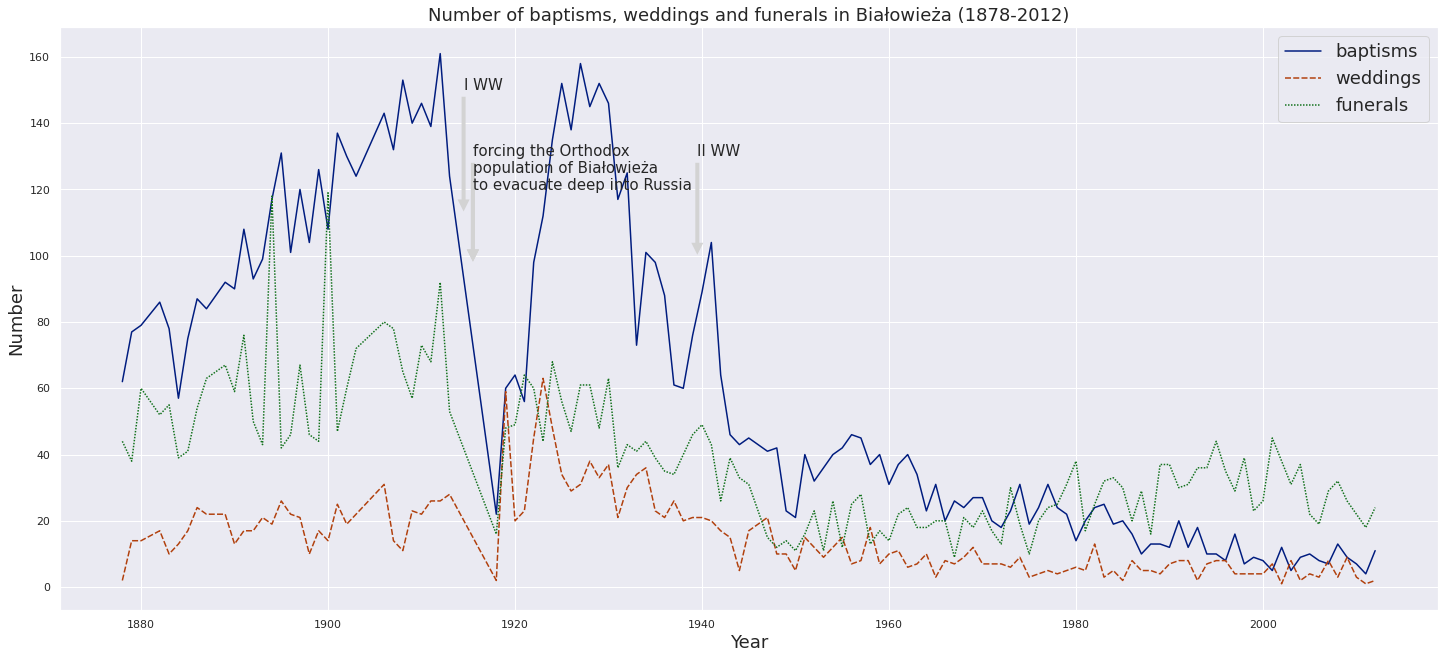

In [ ]:
url_data = (r'https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_visualisation.xlsx?raw=true')
DF = pd.read_excel(url_data)
plt.figure(figsize=(22,10))
plt.title("Number of baptisms, weddings and funerals in Białowieża (1878-2012)", fontsize=18)
g=sns.lineplot(x=DF["rok"], y=DF["liczba odnotowanych"], hue=DF["zdarzenie"], style=DF["zdarzenie"], palette='dark', legend=True, ci=True)

plt.annotate('I WW', xy=(1914.5, 113), xytext=(1914.5, 150), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('II WW', xy=(1939.5, 100), xytext=(1939.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('forcing the Orthodox', xy=(1915.5, 98), xytext=(1915.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('population of Białowieża', xy=(1915.5, 98), xytext=(1915.5, 125), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('to evacuate deep into Russia', xy=(1915.5, 98), xytext=(1915.5, 120), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.ylabel('Number', fontsize=18)
plt.xlabel('Year',fontsize=18 )

plt.legend()
#plt.legend(fontsize=18 )
plt.legend(fontsize=18 ).get_texts()[2].set_text('funerals')


sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')
sns.set_theme()

Some of the information in the data is missing and it is represented on the chart below. As one can see, in late 1910s the village population needed to go into hiding, which caused the lack of records for that time.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


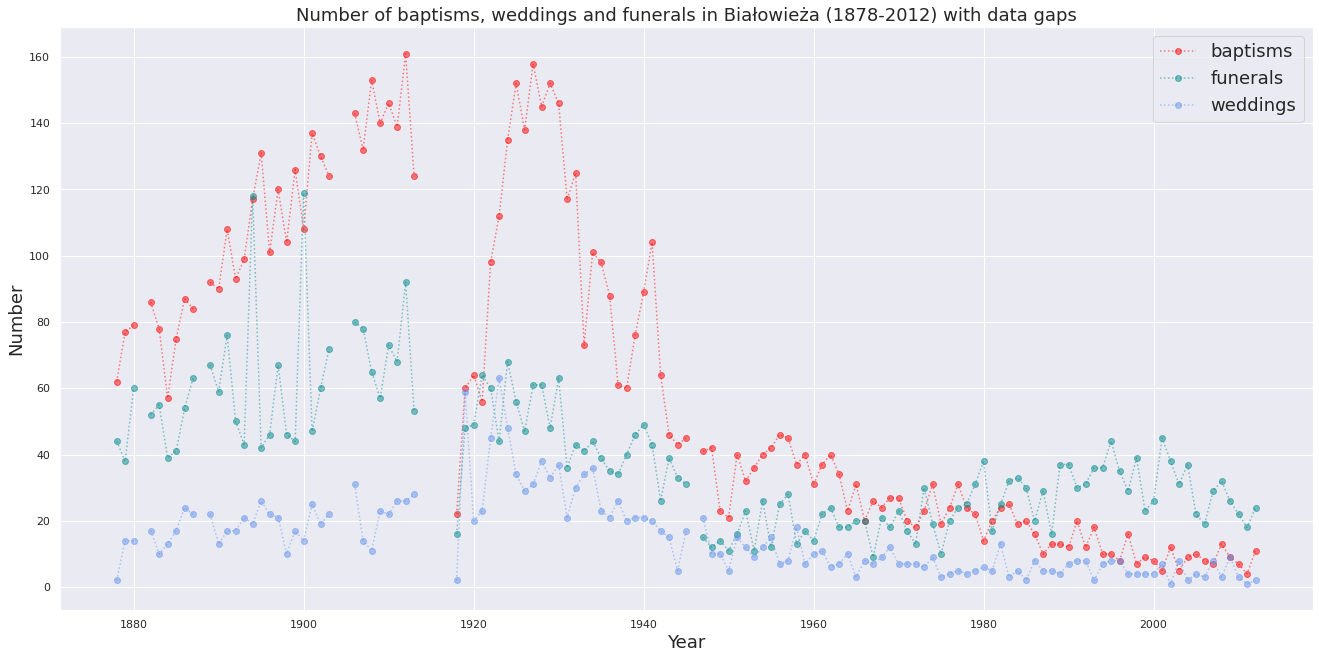

In [ ]:
Data1 = DF[DF['zdarzenie'] == 'baptisms']
Data2 = DF[DF['zdarzenie'] == 'deaths']
Data3 = DF[DF['zdarzenie'] == 'weddings']
Data2['zdarzenie'] = Data2['zdarzenie'].str.replace('deaths','funerals')

cols_plot = [ 'liczba odnotowanych', "rok"]
fig, ax = plt.subplots()
ax.plot(Data1["rok"], Data1["liczba odnotowanych"],marker='o', color="red",alpha=0.5, linestyle='dotted', label='baptisms')
ax.plot(Data2["rok"], Data2["liczba odnotowanych"],marker='o', color="darkcyan",alpha=0.5, linestyle='dotted', label='funerals')
ax.plot(Data3["rok"], Data3["liczba odnotowanych"],marker='o', color="cornflowerblue",alpha=0.5, linestyle='dotted', label='weddings')
plt.title("Number of baptisms, weddings and funerals in Białowieża (1878-2012) with data gaps", fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number', fontsize=18)

L=plt.legend()
plt.legend(fontsize=18 )

fig.set_size_inches(20, 10)

The data is incomplete (most likely due to historical events during this period),and the longest break relates to the years 1914-1917. We can assume that it was influenced by World War I (beginning on July 28, 1914 - ending on November 11, 1918); the front was near Białowieża. It also turns out that during World War I, the Orthodox population of Białowieża was displaced and evacuated deep into Russia. 

After World War I, there was relative peace and appropriate conditions for starting a family. Therefore, in the interwar decade, i.e., from 1922 to 1932, a significant increase in births can be observed.

In 1941, the number of funerals and baptisms significantly decreased, caused by the mass displacement of the people of Białowieża to Siberia.

After World War II, the number of baptisms and funerals successively decreased, which led to a decline in the number of inhabitants of Białowieża and the conclusion that there are less and less Orthodox Christians in this area.


In the following graphs we can see some statistics for the variables from the original dataset.

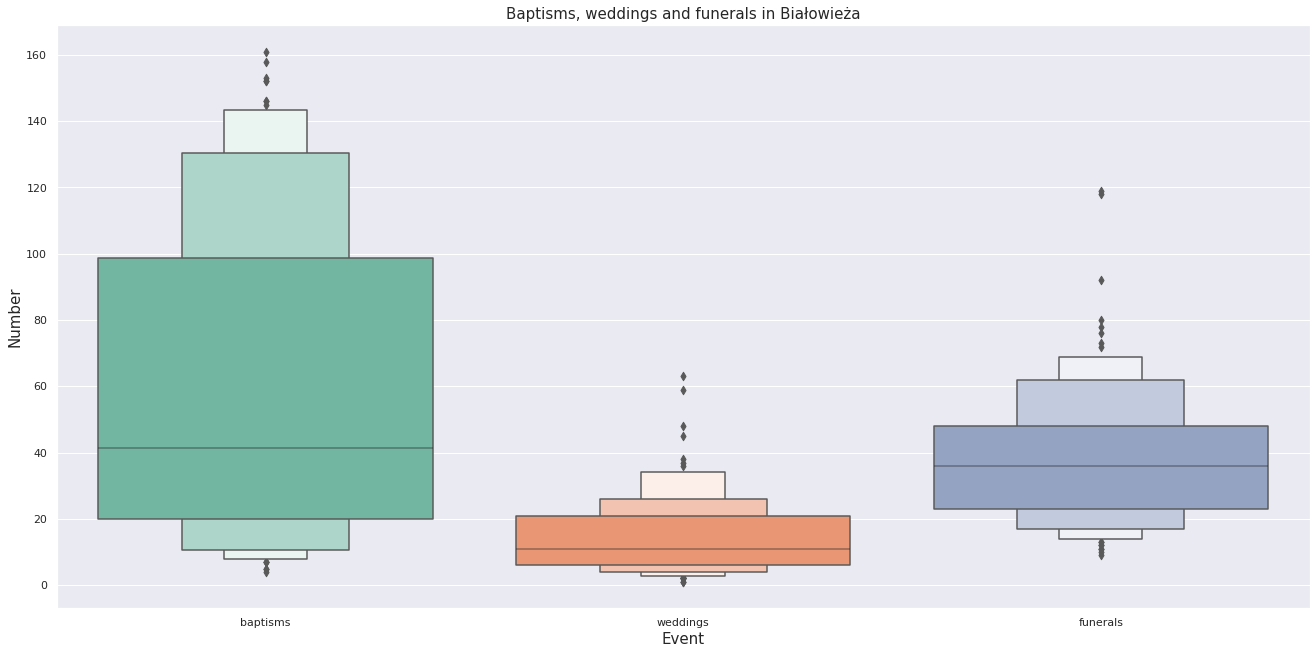

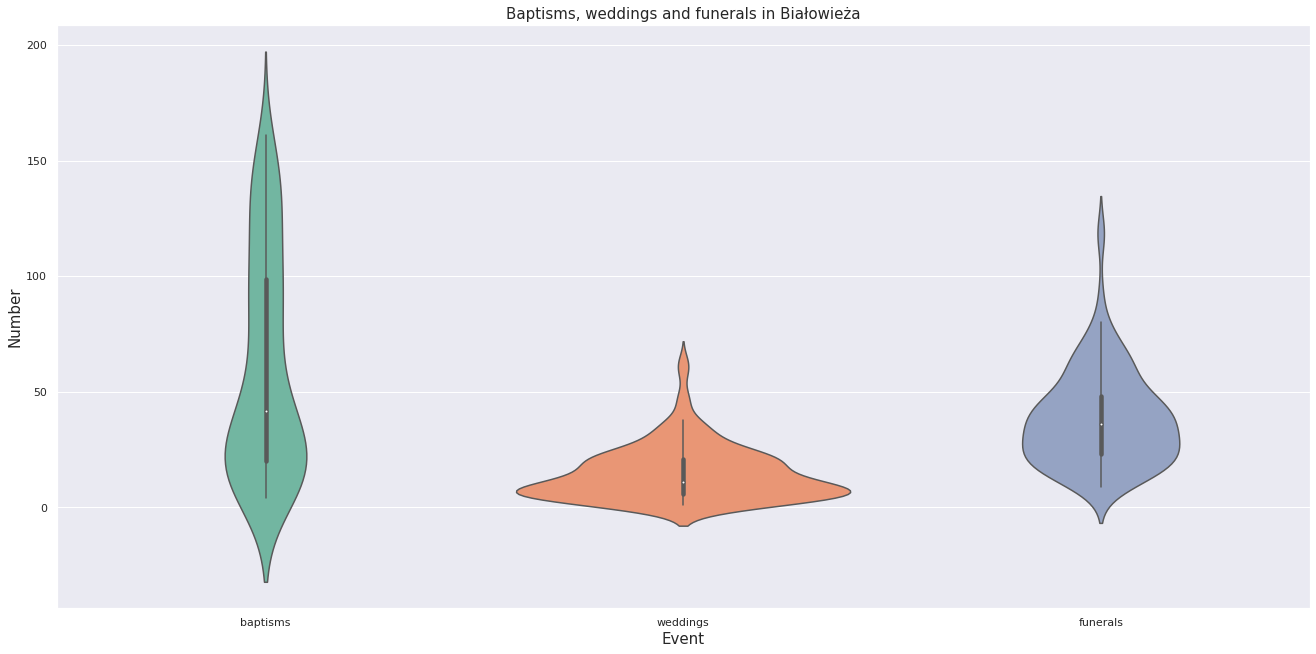

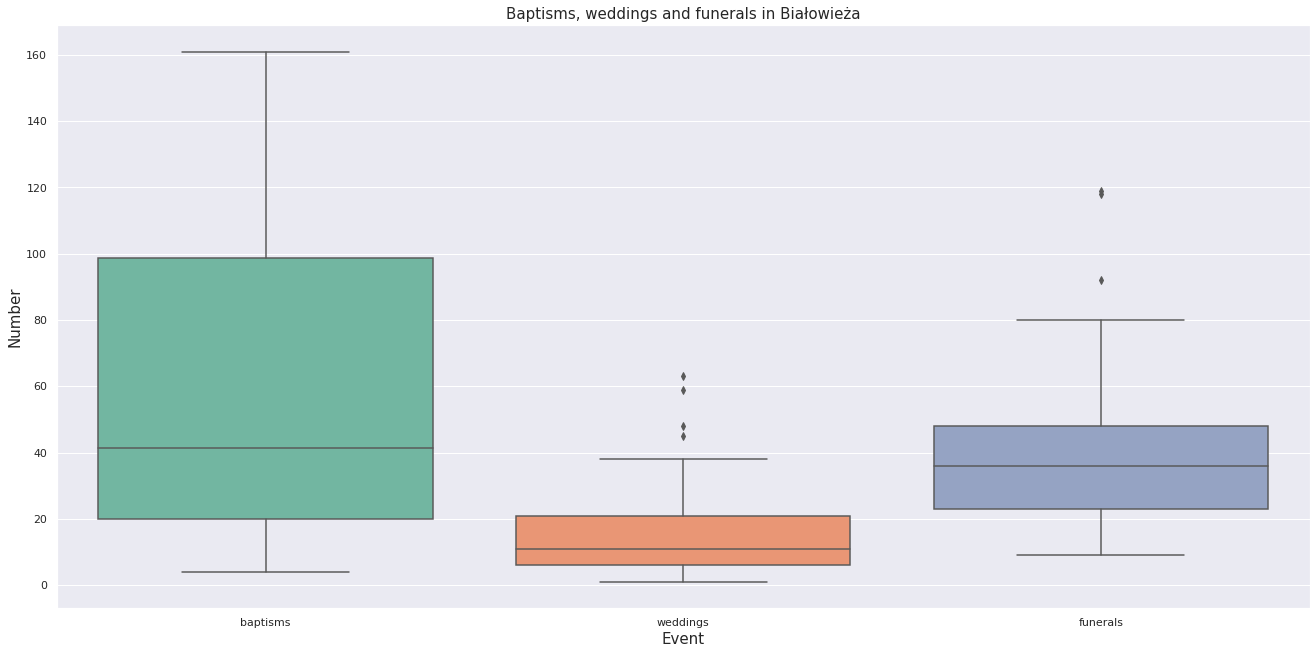

In [ ]:
DF['zdarzenie'].replace({'deaths': 'funerals'}, inplace=True)

plt.figure(figsize=(20, 10))
sns.boxenplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and funerals in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

plt.figure(figsize=(20, 10))
sns.violinplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and funerals in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and funerals in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

Visualisation of distributions

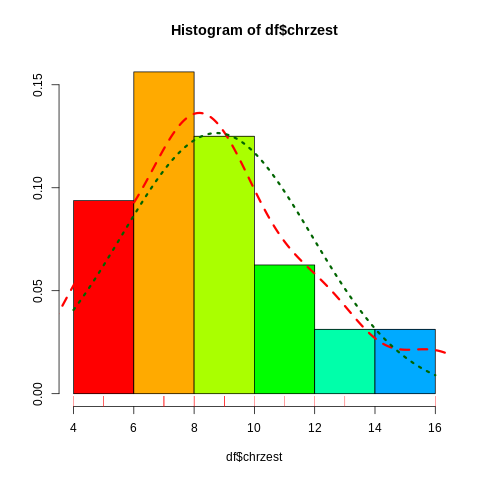

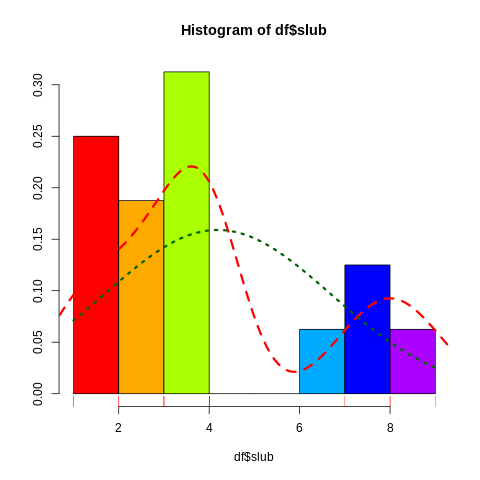

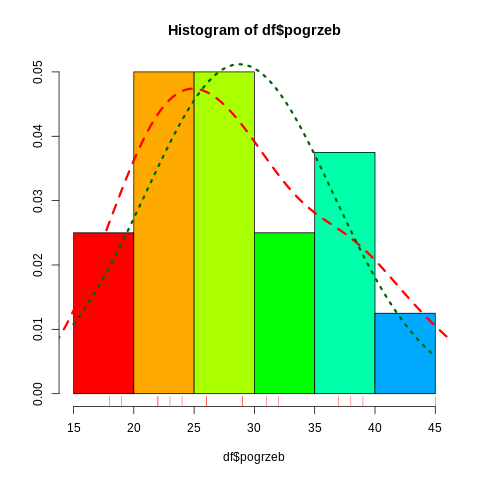

In [ ]:
%%R
df <- read_csv("df_bialowieza.csv")
hist(df$chrzest, breaks=7, col=rainbow(9),ylab="",
     probability=T)
rug(df$chrzest,col="red")
lines(density(df$chrzest),lty=2, lwd=3, col="red")
curve(dnorm(x, mean = mean(df$chrzest), sd =sd(df$chrzest)) , add=T , col="darkgreen", lty=3, lwd =3) 

hist(df$slub, breaks=7, col=rainbow(9),ylab="",
     probability=T)
rug(df$slub,col="red")
lines(density(df$slub),lty=2, lwd=3, col="red")
curve(dnorm(x, mean = mean(df$slub), sd =sd(df$slub)) , add=T , col="darkgreen", lty=3, lwd =3) 


hist(df$pogrzeb, breaks=7, col=rainbow(9),ylab="",
     probability=T)
rug(df$pogrzeb,col="red")
lines(density(df$pogrzeb),lty=2, lwd=3, col="red")
curve(dnorm(x, mean = mean(df$pogrzeb), sd =sd(df$pogrzeb)) , add=T , col="darkgreen", lty=3, lwd =3) 

Skweness and kurtosis

In [ ]:
%%R
skewness_baptism <- skewness(df$chrzest) 
kurtosis_baptism <- kurtosis(df$chrzest)
skewness_wed <- skewness(df$slub) 
kurtosis_wed <- kurtosis(df$slub)
skewness_funeral <- skewness(df$pogrzeb) 
kurtosis_funeral <- kurtosis(df$pogrzeb)

skwe_kurt <- c(skewness_baptism, kurtosis_baptism, skewness_wed, kurtosis_wed, skewness_funeral, kurtosis_funeral)
text <- c("skewness_baptism", "kurtosis_baptism", "skewness_wed", "kurtosis_wed", "skewness_funral", "kurtosis_funeral")

skwe_kurt <- data.frame(info = text, value =skwe_kurt)
skwe_kurt

              info      value
1 skewness_baptism  0.5509936
2 kurtosis_baptism -0.3636771
3     skewness_wed  0.6083892
4     kurtosis_wed -0.9821363
5  skewness_funral  0.4811252
6 kurtosis_funeral -0.9477333


Baptisms have the greatest variation in data, while data for weddings are the most concentrated.
Baptisms and funerals have similar mean values (around 40). For weddings, the value is below 20.
Similarly for the median - the difference between baptisms and funerals is not large (white points in the second graph).
The most outlier observations were identified for funerals, but these were for all three variables).

linear dependence model

R[write to console]: `geom_smooth()` using formula 'y ~ x'



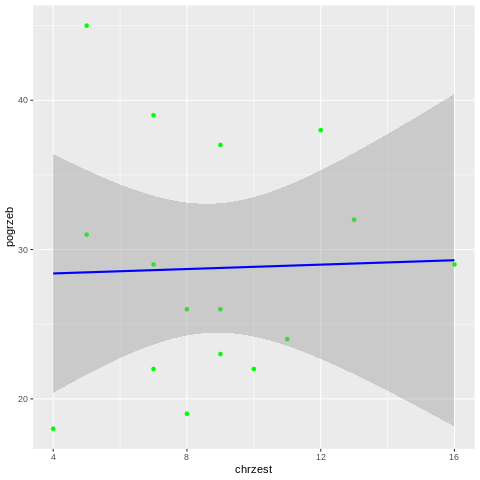

In [ ]:
%%R

bapt.lm <- lm(chrzest ~ pogrzeb, data = df)
summary(bapt.lm)


bapt.graph<-ggplot(df, aes(x=chrzest, y=pogrzeb))+
                        geom_point(col="green")+ 
            geom_smooth(method="lm", col="blue")
bapt.graph

In [ ]:
%%R
bapt.lm


Call:
lm(formula = chrzest ~ pogrzeb, data = df)

Coefficients:
(Intercept)      pogrzeb  
    8.40285      0.01207  



Linear dependece model for x = baptism and y = funeral is:
 > Baptism = 10.44 -0.03*funerals
 > the dependency is almost flat, but negative

R[write to console]: `geom_smooth()` using formula 'y ~ x'



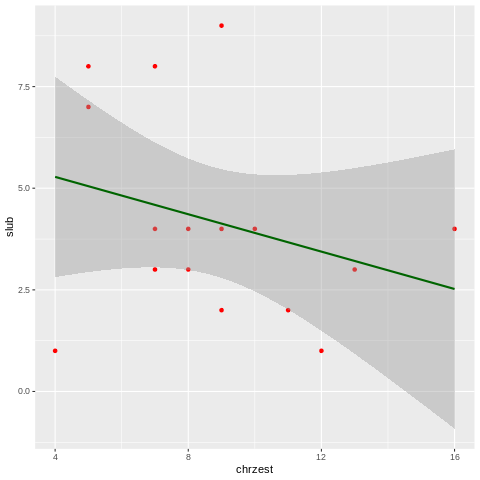

In [ ]:
%%R
wed.lm <- lm(chrzest ~ slub, data = df)
summary(wed.lm)


wed.graph<-ggplot(df, aes(x=chrzest, y=slub))+
                        geom_point(col="red")+ 
            geom_smooth(method="lm", col="darkgreen")

wed.graph

In [ ]:
%%R
wed.lm


Call:
lm(formula = chrzest ~ slub, data = df)

Coefficients:
(Intercept)         slub  
    10.2687      -0.3627  



Linear dependece model for x = baptism and y = weddings is:
 > Baptism = 11.24 -0.5*weddings
 > the dependency is negative

R[write to console]: `geom_smooth()` using formula 'y ~ x'



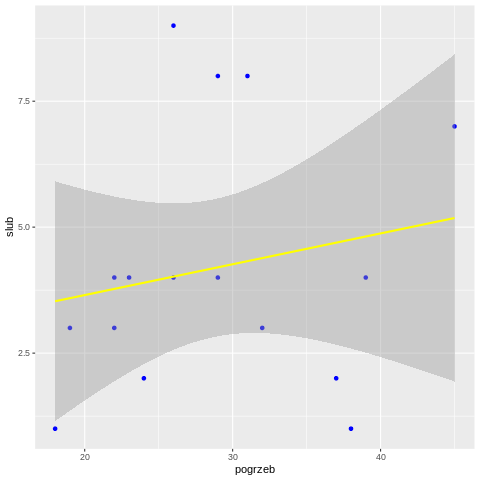

In [ ]:
%%R
de.lm <- lm(pogrzeb ~ slub, data = df)
summary(de.lm)


de.graph<-ggplot(df, aes(x=pogrzeb, y=slub))+
                        geom_point(col="blue")+ 
            geom_smooth(method="lm", col="yellow")

de.graph

In [ ]:
%%R
de.lm



Call:
lm(formula = pogrzeb ~ slub, data = df)

Coefficients:
(Intercept)         slub  
    26.2780       0.5903  



Linear dependece model for x = funerlas and y = weddings is:
 > Baptism = 24.63 +0,82*weddings
 the dependency is positive

# ***analysis***

##***dependency analysis***

In [ ]:
merged_df = pd.merge(df_aggregateddata, DF, on="rok")

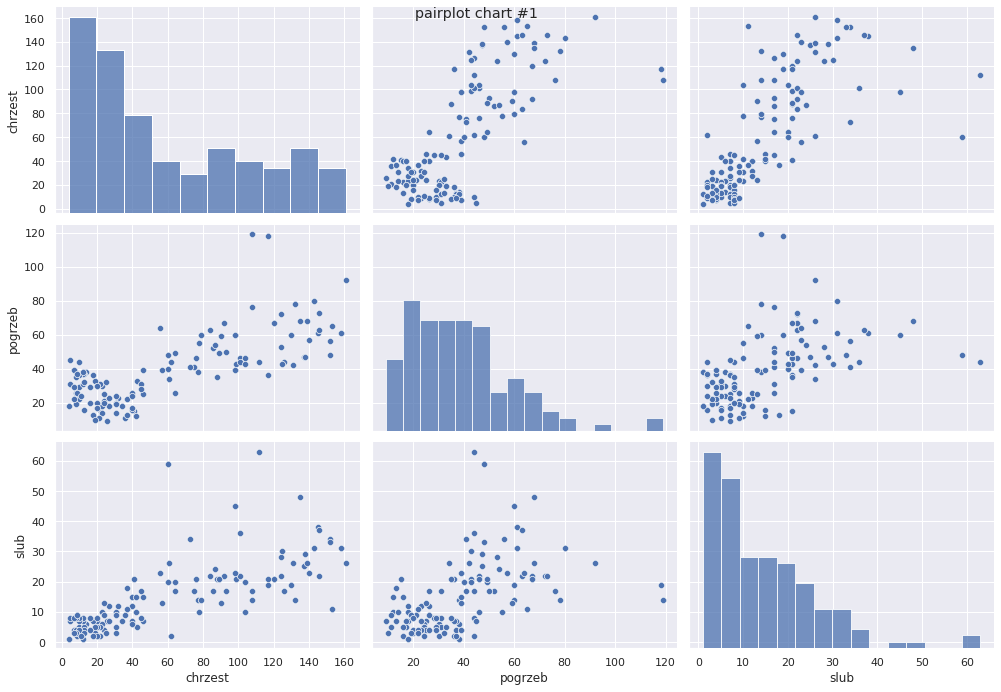

In [ ]:
g=sns.pairplot(merged_df, x_vars=["chrzest", "pogrzeb", "slub"], y_vars=["chrzest", "pogrzeb", "slub"])
g.fig.suptitle("pairplot chart #1")
g.fig.set_size_inches(15,10)

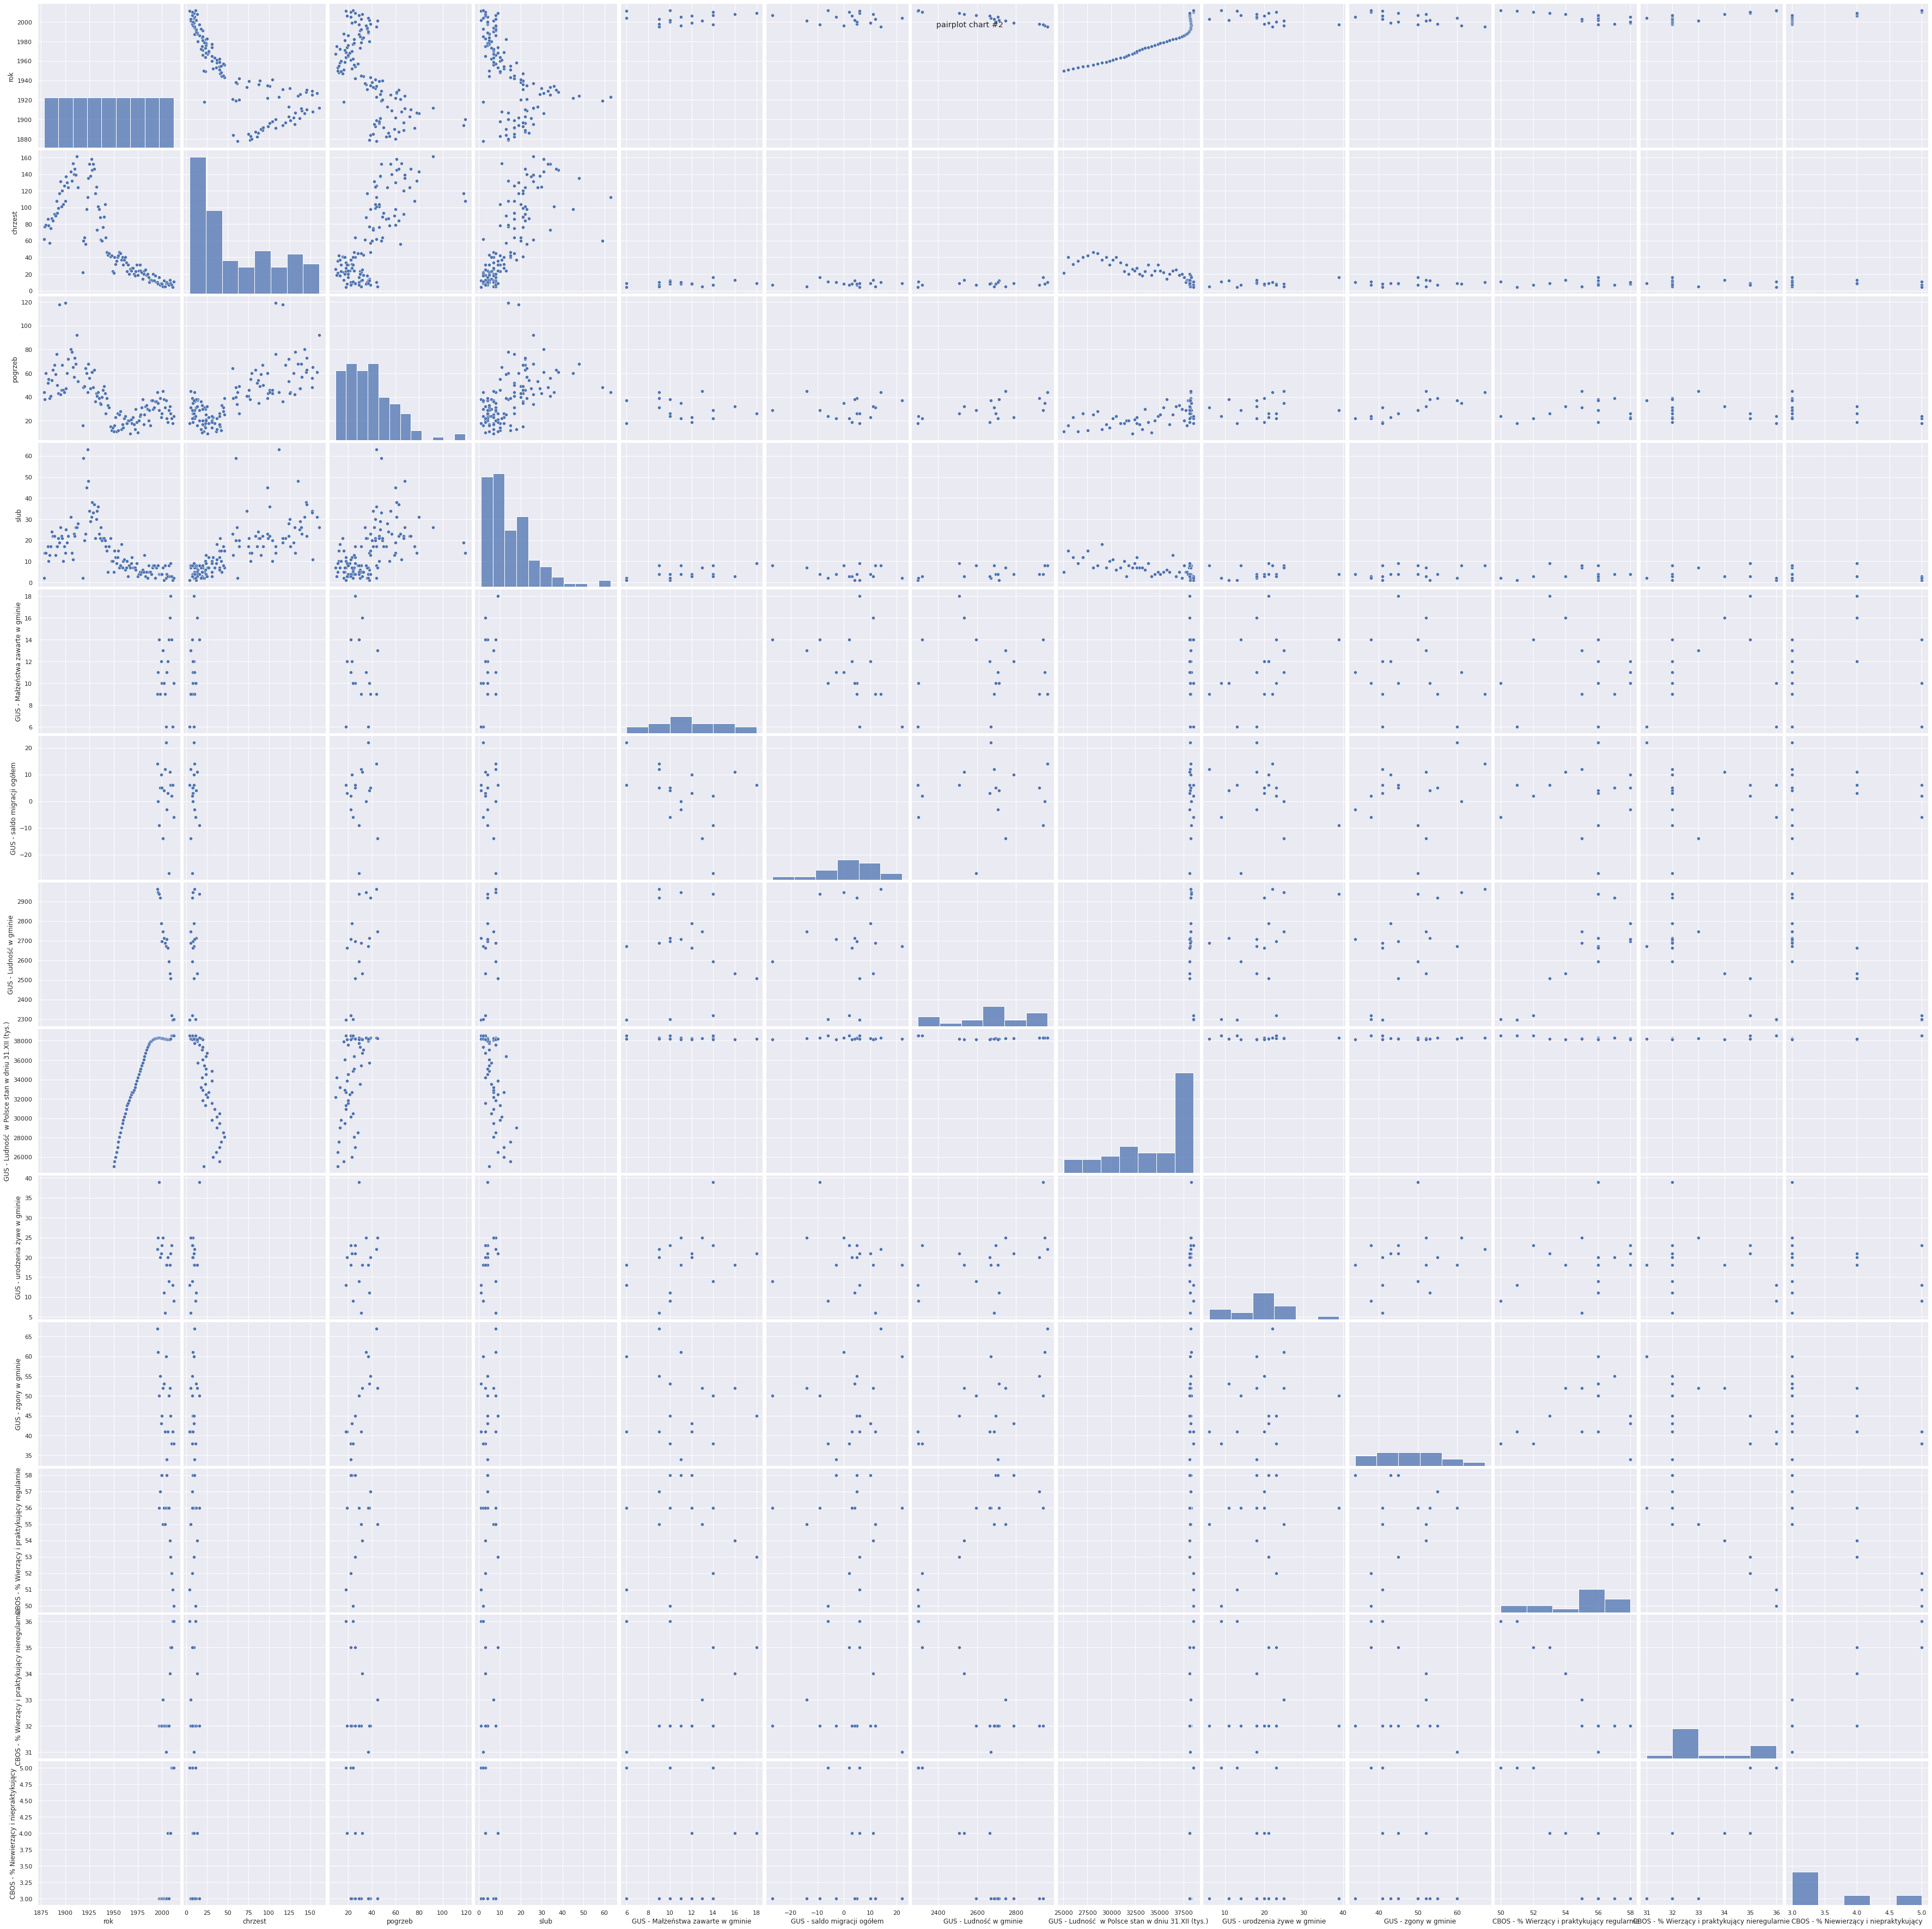

In [ ]:
g=sns.pairplot(df_aggregateddata, y_vars=["rok", "chrzest", "pogrzeb", "slub", "GUS - Małżeństwa zawarte w gminie", "GUS - saldo migracji ogółem", "GUS - Ludność w gminie",
                                  "GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)", "GUS - urodzenia żywe w gminie", "GUS - zgony w gminie",
                                  "CBOS - % Wierzący i praktykujący regularnie", "CBOS - % Wierzący i praktykujący nieregularnie", "CBOS - % Niewierzący i niepraktykujący"],
               x_vars= ["rok", "chrzest", "pogrzeb", "slub", "GUS - Małżeństwa zawarte w gminie", "GUS - saldo migracji ogółem", "GUS - Ludność w gminie",
                                  "GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)", "GUS - urodzenia żywe w gminie", "GUS - zgony w gminie",
                                  "CBOS - % Wierzący i praktykujący regularnie", "CBOS - % Wierzący i praktykujący nieregularnie", "CBOS - % Niewierzący i niepraktykujący"], height=5, dropna=True)
g.fig.suptitle("pairplot chart #2")
g.fig.set_size_inches(50,50)

Pair plot shows catterplot matrix it is used to understand the best set of features to explain a relationship between two variables.
The histogram on the diagonal allows us to see the distribution of a single variable while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) between two variables.
Baptisms, marriages, funerals, and total migration balance have right-skewed distributions.
Population in Poland is the only variable with a left-skewed distribution. 

From the matrix, we can infer the existence of relationships between the following pairs of variables:
* weddings-baptisms
* weddings - funerals
* funerals - baptisms
* population in Poland - baptisms
* population in commune - percentage of non-believers and non-baptists
* population in commune - percentage of believers and irregular practitioners
* population in commune - percentage of believers and practicing regularly 
(relationship stronger than the previous two pairs)
* funerals - deaths in the commune
* funerals - percentage of believers and practicing irregularly
* funerals - percentage of believers and regular practitioners
* funerals - percentage of non-believers and non-practitioners (the more funerals the fewer non-believers - this is quite surprising as younger people are more likely to declare themselves non-believers than older people who are more likely to die)
* a relationship also exists between the three variables of religiosity






## ***correlation***

In [ ]:
#correlation
korel = df_aggregateddata.corr()
df_aggregateddata.corr()

,rok,chrzest,slub,pogrzeb,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
rok,1.000000,-0.800298,-0.571327,-0.630441,0.174220,-0.116008,-0.958872,0.938971,-0.509504,-0.634928,-0.799034,0.771744,0.834380
chrzest,-0.800298,1.000000,0.734576,0.740269,0.326517,0.019477,0.239191,-0.861808,0.380729,0.167780,0.131010,-0.129532,-0.123442
slub,-0.571327,0.734576,1.000000,0.506627,0.379970,-0.233923,0.387479,-0.585242,0.149044,0.292203,0.149049,-0.130163,-0.348871
pogrzeb,-0.630441,0.740269,0.506627,1.000000,-0.127775,0.072397,0.595813,0.590339,0.125313,0.830574,0.251019,-0.398130,-0.564912
GUS - Małżeństwa zawarte w gminie,0.174220,0.326517,0.379970,-0.127775,1.000000,-0.394442,-0.084316,-0.292229,0.371042,-0.162783,-0.053226,0.185199,0.061927
GUS - saldo migracji ogółem,-0.116008,0.019477,-0.233923,0.072397,-0.394442,1.000000,0.059270,-0.011198,-0.157871,0.202578,0.033515,-0.060023,0.062425
GUS - Ludność w gminie,-0.958872,0.239191,0.387479,0.595813,-0.084316,0.059270,1.000000,-0.476832,0.491446,0.625460,0.847721,-0.843724,-0.887398
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.938971,-0.861808,-0.585242,0.590339,-0.292229,-0.011198,-0.476832,1.000000,-0.037536,-0.252576,-0.681737,0.706786,0.714245
GUS - urodzenia żywe w gminie,-0.509504,0.380729,0.149044,0.125313,0.371042,-0.157871,0.491446,-0.037536,1.000000,0.277264,0.295612,-0.192600,-0.205951
GUS - zgony w gminie,-0.634928,0.167780,0.292203,0.830574,-0.162783,0.202578,0.625460,-0.252576,0.277264,1.000000,0.276014,-0.433777,-0.487412


The correlation matrix shows that the highest (above 0,8 / lower then -0,8)correlations were recorded between the following pairs of variables:

* year - population in municipality (-0.97)
* Percentage of believers practicing regularly - Percentage of believers  practicing irregularly(-0.94)
* Percentage of non-believers and non-practitioners - Percentage of believers practicing regularly(-0.94)
* year - percentage of believers and regular practitioners (-0.93)
* Population in the municipality - percentage of believers and regular practitioners (0.93)
* Population in municipality - percentage of believers practicing irregularly (-0.92)
* Population in municipality - percentage of non-believers and non-practitioners (0.92)
* year - percentage of persons believing and not practicing (0.92)
* year - population in Poland - balance (0.91)
* year - percentage of believers practicing irregularly (0.89)
* baptism - population in Poland - balance (-0.86)
* funerals - deaths in the municipality (0.83)
* year - baptism ( -0.8)
* Percentage of believers and those who practice irregularly - Population in Poland - outstanding balance (0.77)
* Percentage of non-believers and non-practitioners - population in Poland - balance (0.76)
* Percentage of believers and regular practitioners - Poland's population - average (0.74)
* Percentage of persons who do not believe and practice regularly - Percentage of persons who believe and practice irregularly(-0.90)
* funerals - baptism (0.74)
* marriage - baptism (0.73)

## ***filling in data gaps***
There is a large amount of data gaps in the dataset. This is mostly due to the fact that variables from other sources than orthodox church records weren't available as early as 1878.

In [ ]:
# sum of data gaps
df_aggregateddata.isnull().sum()

rok                                                    0
chrzest                                                9
slub                                                   9
pogrzeb                                                9
GUS - Małżeństwa zawarte w gminie                    117
GUS - saldo migracji ogółem                          117
GUS - Ludność w gminie                               117
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     72
GUS - urodzenia żywe w gminie                        117
GUS - zgony w gminie                                 117
CBOS - % Wierzący i praktykujący regularnie          119
CBOS - % Wierzący i praktykujący nieregularnie       119
CBOS - % Niewierzący i niepraktykujący               119
dtype: int64

In [ ]:
CORREL = df_aggregateddata.corr()
CORREL['chrzest'].to_frame().sort_values('chrzest')
CORREL = df_aggregateddata.corr()
CORREL['slub'].to_frame().sort_values('slub')
CORREL = df_aggregateddata.corr()
CORREL['pogrzeb'].to_frame().sort_values('pogrzeb')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Małżeństwa zawarte w gminie'].to_frame().sort_values('GUS - Małżeństwa zawarte w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - saldo migracji ogółem'].to_frame().sort_values('GUS - saldo migracji ogółem')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność w gminie'].to_frame().sort_values('GUS - Ludność w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].to_frame().sort_values('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')
CORREL = df_aggregateddata.corr()
CORREL['GUS - urodzenia żywe w gminie'].to_frame().sort_values('GUS - urodzenia żywe w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - zgony w gminie'].to_frame().sort_values('GUS - zgony w gminie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący regularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący regularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący nieregularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący nieregularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Niewierzący i niepraktykujący'].to_frame().sort_values('CBOS - % Niewierzący i niepraktykujący')

,CBOS - % Niewierzący i niepraktykujący
GUS - Ludność w gminie,-0.887398
CBOS - % Wierzący i praktykujący regularnie,-0.883606
pogrzeb,-0.564912
GUS - zgony w gminie,-0.487412
slub,-0.348871
GUS - urodzenia żywe w gminie,-0.205951
chrzest,-0.123442
GUS - Małżeństwa zawarte w gminie,0.061927
GUS - saldo migracji ogółem,0.062425
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.714245


In [ ]:
df_aggregateddata['chrzest'] = df_aggregateddata.groupby('pogrzeb')['chrzest'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['chrzest'].fillna(method='ffill', inplace=True)  
df_aggregateddata['pogrzeb'] = df_aggregateddata.groupby('GUS - zgony w gminie')['pogrzeb'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['pogrzeb'].fillna(method='ffill', inplace=True)  
df_aggregateddata['slub'] = df_aggregateddata.groupby('chrzest')['slub'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['slub'].fillna(method='ffill', inplace=True)  
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'] = df_aggregateddata.groupby('GUS - urodzenia żywe w gminie')['GUS - Małżeństwa zawarte w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - saldo migracji ogółem'] = df_aggregateddata.groupby('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')['GUS - saldo migracji ogółem'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - saldo migracji ogółem'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność w gminie'] = df_aggregateddata.groupby('CBOS - % Wierzący i praktykujący regularnie')['GUS - Ludność w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'] = df_aggregateddata.groupby('rok')['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - urodzenia żywe w gminie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['GUS - urodzenia żywe w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - urodzenia żywe w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - zgony w gminie'] = df_aggregateddata.groupby('pogrzeb')['GUS - zgony w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - zgony w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['CBOS - % Wierzący i praktykujący regularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'] = df_aggregateddata.groupby('CBOS - % Niewierzący i niepraktykujący')['CBOS - % Wierzący i praktykujący nieregularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'] = df_aggregateddata.groupby('rok')['CBOS - % Niewierzący i niepraktykujący'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'].fillna(method='ffill', inplace=True) 


df_aggregateddata.to_csv(r'fillna_data_bialowieza.csv', index = False)

In [ ]:
df_aggregateddata.isnull().sum()

rok                                                    0
chrzest                                                0
slub                                                   0
pogrzeb                                              117
GUS - Małżeństwa zawarte w gminie                    117
GUS - saldo migracji ogółem                          117
GUS - Ludność w gminie                               119
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     72
GUS - urodzenia żywe w gminie                        119
GUS - zgony w gminie                                 117
CBOS - % Wierzący i praktykujący regularnie          119
CBOS - % Wierzący i praktykujący nieregularnie       119
CBOS - % Niewierzący i niepraktykujący               119
dtype: int64

Based on correlations found between individual variables, data gaps were partially filled.


In [ ]:
df_aggregateddata.dropna(inplace=True)
df_aggregateddata.to_csv(r'df_bialowieza.csv', index = False)

To allow further work on the collection, the remaining missing data was removed.
A table with the observations that remained in the collection is shown below.

In [ ]:
df_aggregateddata

,rok,chrzest,slub,pogrzeb,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
119,1997,16.0,4.0,29.0,14.0,-9.0,2938.0,38290.0,39.0,50.0,56.0,32.0,3.0
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0


## ***Regression***

### `"baptism"  as the dependent variable`


In [ ]:
X = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y = df_aggregateddata["chrzest"].values.reshape(-1,1)
linear_regressor = LinearRegression().fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2.069
Date:                Fri, 18 Feb 2022   Prob (F-statistic):              0.300
Time:                        01:15:25   Log-Likelihood:                -22.735
No. Observations:                  16   AIC:                             71.47
Df Residuals:                       3   BIC:                             81.51
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


The model created from the regression has a great fit of 0.892.
For no variable, p-value is less than/equal to 0.05.
The variable "%neither believing nor practicing " appeared to have the greatest effect on the number of baptisms (-9,49) while the smallest impact has "live births in the municipality" - almost zero (0,0054).
Despite the above problems, we tested the difference between the prediction and the real values. The effects can be seen in the graph below.

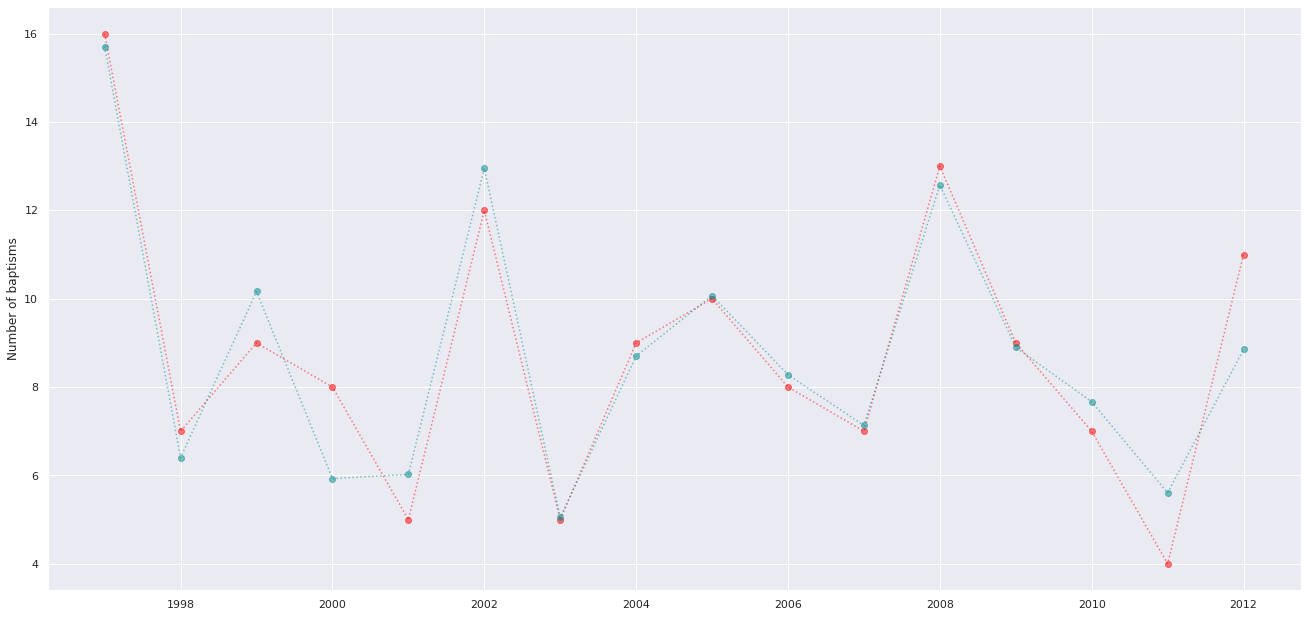

In [ ]:
df_aggregateddata['Y_pred'] = Y_pred
fig, ax = plt.subplots()
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["chrzest"],marker='o',alpha=0.5, linestyle='dotted', color="red")
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["Y_pred"],marker='o',alpha=0.5, linestyle='dotted', color="darkcyan")
ax.set_ylabel('Number of baptisms')
fig.set_size_inches(20, 10)

* The largest differences between projected and real values were in 1998 and 2011.

* The best predicted values were for the following years: 2003, 2005, 2009

## `"wedding" as the dependent variable`




In [ ]:
X = df_aggregateddata.iloc[:, df_aggregateddata.columns != "slub"]
Y = df_aggregateddata["slub"].values.reshape(-1,1)
linear_regressor = LinearRegression().fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.995e+23
Date:                Fri, 18 Feb 2022   Prob (F-statistic):           5.01e-24
Time:                        01:15:26   Log-Likelihood:                 407.27
No. Observations:                  16   AIC:                            -786.5
Df Residuals:                       2   BIC:                            -775.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


The model created from the regression has a fit of 1. For almost all variables, p-value is less then to 0.05, except baptism

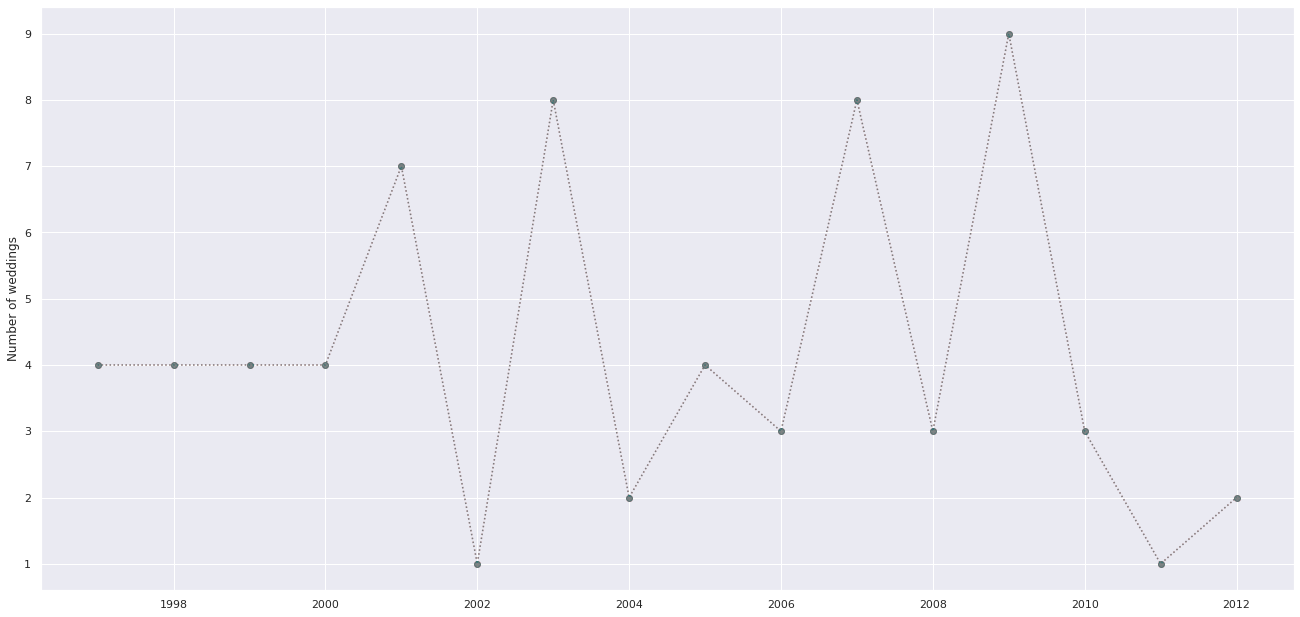

In [ ]:
df_aggregateddata['Y_pred'] = Y_pred
fig, ax = plt.subplots()
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["slub"],marker='o',alpha=0.5, linestyle='dotted', color="red")
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["Y_pred"],marker='o',alpha=0.5, linestyle='dotted', color="darkcyan")
ax.set_ylabel('Number of weddings')
fig.set_size_inches(20, 10)

## `"funerals" as the dependent variable`


In [ ]:
X = df_aggregateddata.iloc[:, df_aggregateddata.columns != "pogrzeb"]
Y = df_aggregateddata["pogrzeb"].values.reshape(-1,1)
linear_regressor = LinearRegression().fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     2.144
Date:                Fri, 18 Feb 2022   Prob (F-statistic):              0.289
Time:                        01:15:26   Log-Likelihood:                -36.965
No. Observations:                  16   AIC:                             99.93
Df Residuals:                       3   BIC:                             110.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


The model created from the regression has a great fit of 0.896.
For no variable, p-value is less than/equal to 0.05.
The variable "%neither believing nor practicing " appeared to have the greatest effect on the number of baptisms (-19,64) while the smallest impact has "% Irregular believers and practitioners"- almost zero (0,016).
Despite the above problems, we tested the difference between the prediction and the real values. The effects can be seen in the graph below.

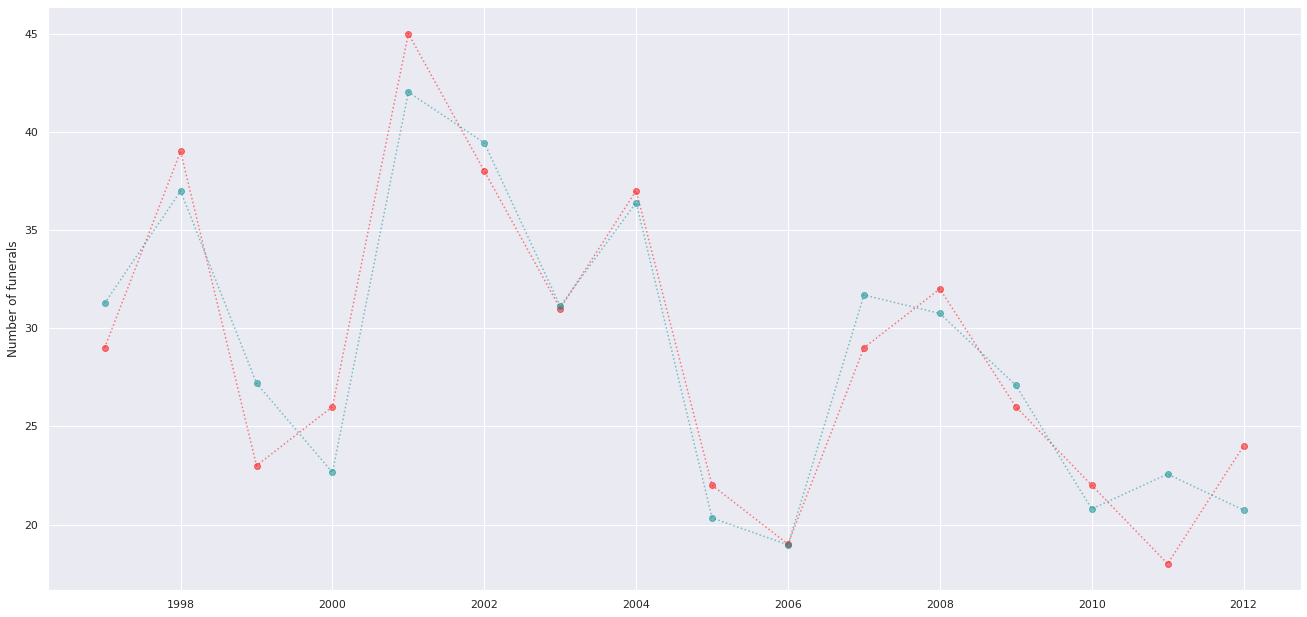

In [ ]:
df_aggregateddata['Y_pred'] = Y_pred
fig, ax = plt.subplots()
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["pogrzeb"],marker='o',alpha=0.5, linestyle='dotted', color="red")
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["Y_pred"],marker='o',alpha=0.5, linestyle='dotted', color="darkcyan")
ax.set_ylabel('Number of funerals')
fig.set_size_inches(20, 10)


* The best predicted values were for the following years: 2003, 2006

## K Means

In addition, we checked whether our initial set (df_aggregateddata) can be partitioned using the K-means method. The goal was to minimize within-group differences and maximize between-group differences.

In [ ]:
kmeans = KMeans(init = "k-means++", n_clusters=2).fit(df_aggregateddata)
labels1 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=3).fit(df_aggregateddata)
labels2 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=4).fit(df_aggregateddata)
labels3 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=5).fit(df_aggregateddata)
labels4 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=6).fit(df_aggregateddata)
labels5 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=7).fit(df_aggregateddata)
labels6 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=8).fit(df_aggregateddata)
labels7 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=9).fit(df_aggregateddata)
labels8 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=10).fit(df_aggregateddata)
labels9 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=11).fit(df_aggregateddata)
labels10 = kmeans.labels_
kmeans = KMeans(init = "k-means++", n_clusters=12).fit(df_aggregateddata)
labels11 = kmeans.labels_

In [ ]:
s1 = silhouette_score(df_aggregateddata, labels1)
s2 = silhouette_score(df_aggregateddata, labels2)
s3 = silhouette_score(df_aggregateddata, labels3)
s4 = silhouette_score(df_aggregateddata, labels4)
s5 = silhouette_score(df_aggregateddata, labels5)
s6 = silhouette_score(df_aggregateddata, labels6)
s7 = silhouette_score(df_aggregateddata, labels7)
s8 = silhouette_score(df_aggregateddata, labels8)
s9 = silhouette_score(df_aggregateddata, labels9)
s10 = silhouette_score(df_aggregateddata, labels10)
s11 = silhouette_score(df_aggregateddata, labels11)
print(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
s = (s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
n_clusters = (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


0.7280483990450137 0.5776678297373374 0.6137216119751387 0.5675275616253016 0.5287942044487137 0.46391651805523126 0.4298163559753868 0.4113136618686315 0.3925037171271387 0.3725649797523826 0.30637385586258914


The highest scores were obtained when two clusters were present, so the data were split into two groups.

Text(0.5, 1.0, 'Visualization of profile results for individual cluster numbers')

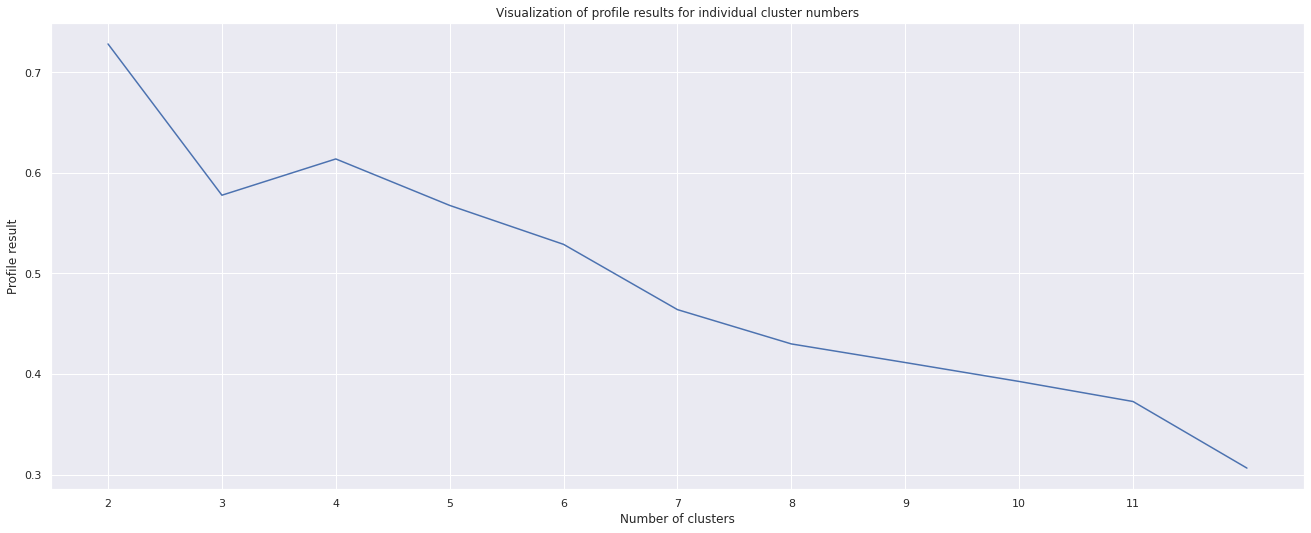

In [ ]:
plt.figure(figsize=(20,8))
g = sns.lineplot(x = n_clusters, y = s)
g.set_xticks(ticks = (2,3,4,5,6,7,8,9,10,11))
g.set(xlabel = "Number of clusters", ylabel = "Profile result");
plt.title('Visualization of profile results for individual cluster numbers')

We split the dataset into two groups according to K-means assumptions:
We added a new column to represent the affiliation to a "0" or "1" cluster.

In [ ]:
df_aggregateddata['Clusters'] = labels1
df_aggregateddata.to_csv(r'df_var.csv', index = False)
df_aggregateddata


,rok,chrzest,slub,pogrzeb,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący,Y_pred,Clusters
119,1997,16.0,4.0,29.0,14.0,-9.0,2938.0,38290.0,39.0,50.0,56.0,32.0,3.0,31.266090,0
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0,36.981339,0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0,27.198621,0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0,22.649414,0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0,42.023690,0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0,39.437314,0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0,31.121846,0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0,36.394755,0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0,20.335116,0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0,18.965698,0


A clear distinction was made between the two time periods 1997-2009 and 2010-2012

basic statistics for both groups:

In [ ]:
df_aggregateddata.groupby(df_aggregateddata['Clusters']).describe()

rok                   ...     Y_pred                      
         count    mean      std  ...        50%        75%        max
Clusters                         ...                                 
0         13.0  2003.0  3.89444  ...  31.121846  36.394755  42.023690
1          3.0  2011.0  1.00000  ...  20.792166  21.680780  22.569394

[2 rows x 112 columns]

We can see the differentiation of data between the two groups

## **Analysis of variance**

By using the analysis of variance, we check whether the values between the designated groups differ significantly

In [ ]:
%%R
options(readr.show_col_types = FALSE)
df_var <- read_csv("df_var.csv")

alfa = 0.1;k=2;n=dim(df_var)[1]
qf(1-alfa,k-1,n-k) 

[1] 3.102213


In [ ]:
%%R
av <- aov(Clusters ~ chrzest, data=df_var)
summary(av) 

            Df Sum Sq Mean Sq F value Pr(>F)
chrzest      1 0.1212  0.1212   0.733  0.406
Residuals   14 2.3163  0.1655               


In [ ]:
%%R
av <- aov(Clusters ~ slub, data=df_var)
summary(av) 

            Df Sum Sq Mean Sq F value Pr(>F)  
slub         1  0.456  0.4560   3.222 0.0943 .
Residuals   14  1.982  0.1415                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
av <- aov(Clusters ~ pogrzeb, data=df_var)
summary(av) 

            Df Sum Sq Mean Sq F value Pr(>F)  
pogrzeb      1 0.5434  0.5434   4.017 0.0648 .
Residuals   14 1.8941  0.1353                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Summary:
* The F critical value is equal to 3,1.
* F value for funerals = 4,017 (>F critical)
* F value for batpisism = 0,733 (< F critical)
* F value for weddings = 3,22 (>F critical)
> Findings : The mean number of funerals and weddings is significantly different in the two clusters. In the case of baptisms, this significance does not occur





## ***PCA*** 


*Due to the previously indicated high correlation, a principal component analysis (PCA) was conducted.

*In this part of the analysis (PCA +FA), we no longer focus on explaining the selected variable. 

*The dataset will be treated as a description of the situation of the Bialowieza community.




In [ ]:
%%R
df <- read_csv("df_bialowieza.csv")
df_PCA <- read_csv("df_bialowieza.csv")

In [ ]:
%%R
summary(df_PCA)

1. PCA analysis based on non-scaled variables:

In [ ]:
%%R
pc <- prcomp(df_PCA, center = TRUE, scale = FALSE)
summary(pc)

Importance of components:
                            PC1      PC2      PC3     PC4     PC5     PC6
Standard deviation     220.9451 104.7988 11.82706 8.68195 6.74749 3.38005
Proportion of Variance   0.8124   0.1828  0.00233 0.00125 0.00076 0.00019
Cumulative Proportion    0.8124   0.9952  0.99754 0.99879 0.99955 0.99974
                           PC7     PC8     PC9    PC10    PC11   PC12    PC13
Standard deviation     2.95027 1.93921 1.30339 1.02133 0.56868 0.4143 0.08599
Proportion of Variance 0.00014 0.00006 0.00003 0.00002 0.00001 0.0000 0.00000
Cumulative Proportion  0.99988 0.99995 0.99997 0.99999 1.00000 1.0000 1.00000


Result : the first two principal components explain more than 90% (99,52%).
The table below shows how much each variable contributes to the Principal Components.

In [ ]:
%%R
pc

Standard deviations (1, .., p=13):
 [1] 220.94505467 104.79880640  11.82705746   8.68195236   6.74748811
 [6]   3.38005405   2.95027459   1.93921310   1.30338509   1.02132895
[11]   0.56868075   0.41432335   0.08599065

Rotation (n x k) = (13 x 13):
                                                            PC1           PC2
rok                                                0.0183323989 -0.0213260625
chrzest                                           -0.0036393564  0.0016017538
slub                                              -0.0035255055 -0.0081606389
pogrzeb                                           -0.0174695881  0.0064308264
GUS - Małżeństwa zawarte w gminie                 -0.0013595824 -0.0110744448
GUS - saldo migracji ogółem                        0.0005769011 -0.0048780524
GUS - Ludność w gminie                            -0.8581232230  0.5114780000
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.5122389815  0.8584362522
GUS - urodzenia żywe w gminie                   

2. PCA analysis based on scaled variables:

scaling of variables


In [ ]:
%%R
df.detr.pc <- prcomp(df_PCA, center = TRUE, scale = TRUE)
summary(df.detr.pc)

Importance of components:
                          PC1    PC2    PC3     PC4    PC5     PC6     PC7
Standard deviation     2.3940 1.4326 1.2611 1.13640 0.9802 0.80584 0.57679
Proportion of Variance 0.4409 0.1579 0.1223 0.09934 0.0739 0.04995 0.02559
Cumulative Proportion  0.4409 0.5988 0.7211 0.82042 0.8943 0.94427 0.96987
                           PC8     PC9    PC10    PC11    PC12    PC13
Standard deviation     0.38979 0.29717 0.27812 0.23460 0.11760 0.07270
Proportion of Variance 0.01169 0.00679 0.00595 0.00423 0.00106 0.00041
Cumulative Proportion  0.98155 0.98835 0.99430 0.99853 0.99959 1.00000


It turned out that after scaling, it takes 6 principal components to get
an explanation of more than 90%.

In [ ]:
%%R
df.detr.pc

Standard deviations (1, .., p=13):
 [1] 2.39402224 1.43261850 1.26107645 1.13640000 0.98017476 0.80583781
 [7] 0.57678609 0.38978516 0.29717108 0.27811980 0.23459685 0.11759547
[13] 0.07270167

Rotation (n x k) = (13 x 13):
                                                           PC1          PC2
rok                                                0.370157634  0.077395746
chrzest                                           -0.097081390  0.166090938
slub                                              -0.114797529  0.439776615
pogrzeb                                           -0.250085545 -0.094305067
GUS - Małżeństwa zawarte w gminie                 -0.013572947  0.638203460
GUS - saldo migracji ogółem                        0.008463552 -0.446296986
GUS - Ludność w gminie                            -0.397063099 -0.006443861
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.303412883 -0.143295446
GUS - urodzenia żywe w gminie                     -0.160373452  0.308419200
GUS - zgony w gm

In [ ]:
%%R
df.detr.pc$sdev

 [1] 2.39402224 1.43261850 1.26107645 1.13640000 0.98017476 0.80583781
 [7] 0.57678609 0.38978516 0.29717108 0.27811980 0.23459685 0.11759547
[13] 0.07270167


PCA - graphs

The following graphs show the relationship between the first two principal components, which together explain 59.9% of the total variation.
Variables are definitely more related to PC1.

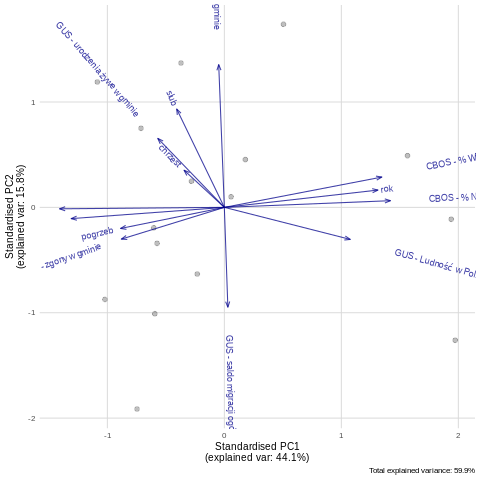

In [ ]:
%%R
ggplot_pca(df.detr.pc)

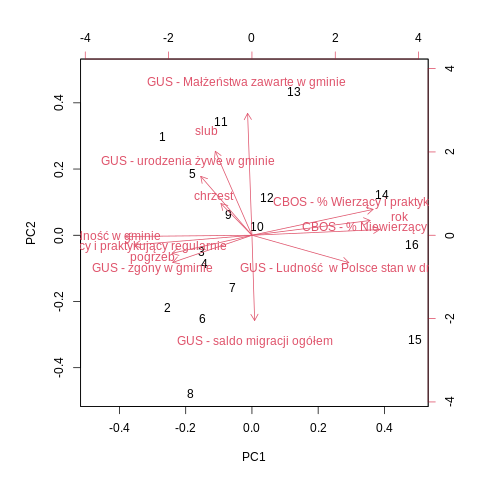

In [ ]:

%%R
biplot(df.detr.pc)

## ***Factor analysis***

In [ ]:
%%R 
install.packages("psych")

In [ ]:
%%R
library(psych)

R[write to console]: 
Attaching package: ‘psych’


R[write to console]: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


R[write to console]: The following object is masked from ‘package:AMR’:

    pca




Exploratory model - EFA

Estimation

In [ ]:
%%R
EFA_Model <- fa(df_PCA)
print(EFA_Model)

Factor Analysis using method =  minres
Call: fa(r = df_PCA)
Standardized loadings (pattern matrix) based upon correlation matrix
                                                    MR1      h2    u2 com
rok                                               -0.87 0.76278 0.237   1
chrzest                                            0.20 0.03861 0.961   1
slub                                               0.23 0.05510 0.945   1
pogrzeb                                            0.53 0.28489 0.715   1
GUS - Małżeństwa zawarte w gminie                  0.02 0.00027 1.000   1
GUS - saldo migracji ogółem                       -0.01 0.00018 1.000   1
GUS - Ludność w gminie                             0.96 0.92721 0.073   1
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) -0.67 0.45354 0.546   1
GUS - urodzenia żywe w gminie                      0.33 0.11010 0.890   1
GUS - zgony w gminie                               0.53 0.27851 0.721   1
CBOS - % Wierzący i praktykujący regularnie        0.87 0

A measure of the fit of the univariate model is the sum of squares, which for our model is 5.45 (the analysis is worth continuing because this value is greater than 1). Based on the result, we can conclude that 42% of the variance is explained using the univariate model.

The RMSR error is low at 0.16

In [ ]:
%%R
EFA_Model$loadings


Loadings:
                                                  MR1   
rok                                               -0.873
chrzest                                            0.196
slub                                               0.235
pogrzeb                                            0.534
GUS - Małżeństwa zawarte w gminie                       
GUS - saldo migracji ogółem                             
GUS - Ludność w gminie                             0.963
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) -0.673
GUS - urodzenia żywe w gminie                      0.332
GUS - zgony w gminie                               0.528
CBOS - % Wierzący i praktykujący regularnie        0.875
CBOS - % Wierzący i praktykujący nieregularnie    -0.907
CBOS - % Niewierzący i niepraktykujący            -0.976

                 MR1
SS loadings    5.451
Proportion Var 0.419


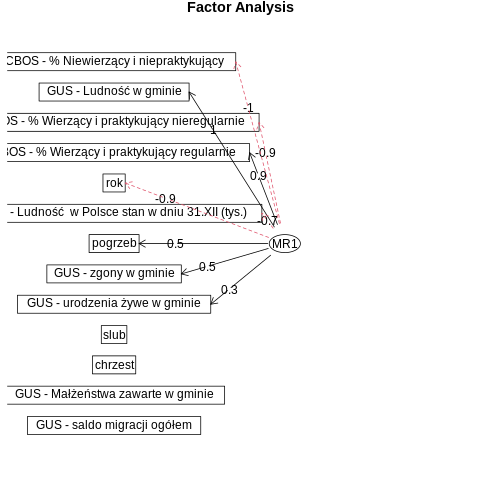

In [ ]:
%%R
fa.diagram(EFA_Model)

By using the fa() function, each variable was assigned a factor charge. This charge represents strength and direction of relationship between each element and factor. It can take values from -1 to 1. The higher the value, the stronger the relationship. The sign next to the value reflects the direction of the relationship, + indicates the same direction and - the opposite direction.

The strongest relationship with the factor was recorded for variables about (nonb/)eliever and (non/)practicing" "Population in the municipality", "year".

Total migration balance, baptism,weddings show a lack of correlation, so they are not linked to MR1 in the diagram.

In [ ]:
%%R
summary(EFA_Model$scores)

      MR1         
 Min.   :-2.9028  
 1st Qu.:-0.7910  
 Median : 0.4506  
 Mean   : 0.0000  
 3rd Qu.: 0.7920  
 Max.   : 1.6675  


Using a one-dimensional kernel density estimator, we approximated the densities of the data distribution by creating a smoothed density curve in a nonparametric manner.
The blue line is shown for comparison with the normal distribution.
The smoothing of the graph is at 0.61.

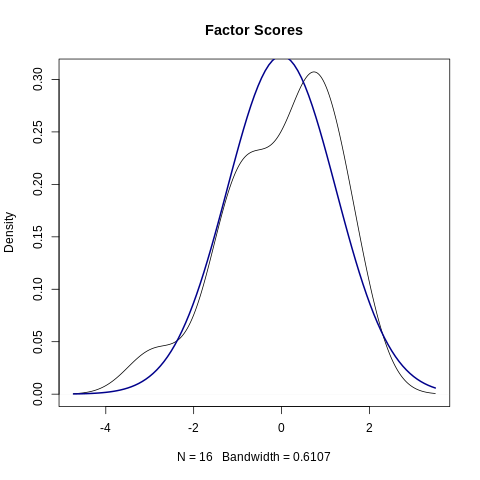

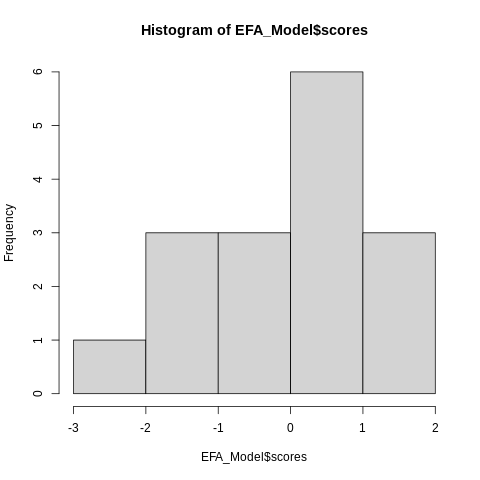

In [ ]:
%%R
m<-mean(EFA_Model$scores)
std<-sqrt(var(EFA_Model$scores))

plot(density(EFA_Model$scores, na.rm = TRUE), 
     main = "Factor Scores")
curve(dnorm(x, mean=m, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")
hist(EFA_Model$scores)

After subjecting the general data to analysis, we proceeded to build the model. In  the following steps:

1. divide the sample into 2 parts (exploratory + confirmatory) with 12 observations per group.
2. comparing the samples whether due to the two subsamples have similar characteristics or different characteristics.

In [ ]:
%%R
N <- nrow(df_PCA)
indices <- seq(1, N)

indices_EFA <- sample(indices, floor(0.5*N))
indices_CFA <- indices[!(indices %in% indices_EFA)]

In [ ]:
%%R
indices_EFA <- gsub(",", "",indices_EFA)
indices_CFA <- gsub(",", "",indices_CFA)
indices_EFA <- as.numeric(indices_EFA)
indices_CFA <- as.numeric(indices_CFA)

describe(indices_EFA)  
indices_EFA <- char2numeric(indices_EFA)  

describe(indices_CFA)  
indices_CFA <- char2numeric(indices_CFA)  

In [ ]:
%%R
fa_EFA <- fa[indices_EFA, ]
fa_CFA <- fa[indices_CFA, ]

R[write to console]: Error in fa[indices_EFA, ] : object of type 'closure' is not subsettable

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs,  :
R[write to console]: 
 
R[write to console]:  The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method.




Error in fa[indices_EFA, ] : object of type 'closure' is not subsettable


RInterpreterError: ignored

characteristics of both groups

In [ ]:
%%R
group_var <- vector("numeric", nrow(df_PCA))
group_var[indices_EFA] <- 1
group_var[indices_CFA] <- 2

fa_grouped <- cbind(df_PCA, group_var)
describeBy(fa_grouped, group = "group_var")


 Descriptive statistics by group 
group_var: 1
                                                  vars n     mean     sd
rok                                                  1 8  2004.12   5.82
chrzest                                              2 8     8.38   3.78
slub                                                 3 8     4.25   2.55
pogrzeb                                              4 8    26.50   6.93
GUS - Małżeństwa zawarte w gminie                    5 8    10.75   2.76
GUS - saldo migracji ogółem                          6 8    -0.75  12.85
GUS - Ludność w gminie                               7 8  2648.38 246.62
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)    8 8 38291.62 164.20
GUS - urodzenia żywe w gminie                        9 8    17.75  10.17
GUS - zgony w gminie                                10 8    44.88   5.99
CBOS - % Wierzący i praktykujący regularnie         11 8    54.88   2.85
CBOS - % Wierzący i praktykujący nieregularnie      12 8    33.00   1.85
CBO

In [ ]:
%%R
lowerCor(df_PCA, use = "pairwise.complete.obs")

                                                  rok   chrzs slub  pgrzb
rok                                                1.00                  
chrzest                                           -0.19  1.00            
slub                                              -0.11 -0.29  1.00      
pogrzeb                                           -0.49  0.03  0.19  1.00
GUS - Małżeństwa zawarte w gminie                  0.11  0.35  0.52 -0.05
GUS - saldo migracji ogółem                       -0.03 -0.01 -0.36 -0.04
GUS - Ludność w gminie                            -0.95  0.26  0.21  0.50
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.37 -0.17 -0.46 -0.33
GUS - urodzenia żywe w gminie                     -0.49  0.40  0.06  0.06
GUS - zgony w gminie                              -0.44  0.18 -0.01  0.80
CBOS - % Wierzący i praktykujący regularnie       -0.80  0.13  0.15  0.25
CBOS - % Wierzący i praktykujący nieregularnie     0.77 -0.13 -0.13 -0.40
CBOS - % Niewierzący i niepraktykujący

In [ ]:
%%R
corr.test(df_PCA, use = "pairwise.complete.obs")$p

                                                           rok   chrzest
rok                                               0.000000e+00 1.0000000
chrzest                                           4.784722e-01 0.0000000
slub                                              6.731082e-01 0.2781193
pogrzeb                                           5.371407e-02 0.9125979
GUS - Małżeństwa zawarte w gminie                 6.963641e-01 0.1814135
GUS - saldo migracji ogółem                       9.060789e-01 0.9718397
GUS - Ludność w gminie                            2.984217e-08 0.3312314
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) 1.537335e-01 0.5369782
GUS - urodzenia żywe w gminie                     5.667502e-02 0.1292340
GUS - zgony w gminie                              8.610839e-02 0.4988940
CBOS - % Wierzący i praktykujący regularnie       2.048163e-04 0.6286518
CBOS - % Wierzący i praktykujący nieregularnie    4.618022e-04 0.6325639
CBOS - % Niewierzący i niepraktykujący            5

In [ ]:
%%R
corr.test(df_PCA, use = "pairwise.complete.obs")$ci

                          lower            r        upper            p
rok-chrzs          -0.627340017 -0.191045082  0.336530369 4.784722e-01
rok-slub           -0.577366657 -0.114404251  0.404225001 6.731082e-01
rok-pgrzb          -0.793329557 -0.490528223  0.006840401 5.371407e-02
rok-G-Mzwg         -0.411425990  0.105871393  0.571579643 6.963641e-01
rok-G-smo          -0.519532789 -0.032092374  0.471107504 9.060789e-01
rok-G-Lwg          -0.981575402 -0.946325914 -0.848784264 2.984217e-08
rok-G-LwPswd3(     -0.149567082  0.373856411  0.733607652 1.537335e-01
rok-G-użwg         -0.790805378 -0.485367062  0.013613714 5.667502e-02
rok-G-zwg          -0.769425030 -0.442488327  0.068169579 8.610839e-02
rok-C-%Wipr        -0.927407033 -0.799034186 -0.502271196 2.048163e-04
rok-C-%Wipn         0.447067173  0.771743633  0.916742360 4.618022e-04
rok-C-%Nin          0.577554662  0.834379661  0.940916049 5.844860e-05
chrzs-slub         -0.686221343 -0.288732187  0.241544454 2.781193e-01
chrzs-

#***appendix***

## ***SNN***
* Spiking neural network was tested to predict orthodox church records, but was deemed unsuccessful due to the small amount of additional supporting data.

* The analysis is illustrative, done with the understanding that the dataset has too few observations to perform a proper SNN analysis 

In [ ]:
X_SNN = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y_SNN = df_aggregateddata["chrzest"].values.reshape(-1,1)

Splitting the dataset into training and testing sections.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X_SNN, Y_SNN, test_size=0.33, random_state=42)

In [ ]:
#X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.10, random_state=1)

In [ ]:
clf = MLPRegressor(solver='adam', learning_rate='adaptive', alpha=1e-5, activation='relu', hidden_layer_sizes=(4,4,4), random_state=2, max_iter=500, batch_size=32)
clf.fit(X_train, Y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:612: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  "Got `batch_size` less than 1 or larger than "


MLPRegressor(alpha=1e-05, batch_size=32, hidden_layer_sizes=(4, 4, 4),
             learning_rate='adaptive', max_iter=500, random_state=2)

In [ ]:
clf.fit(X_train, Y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:612: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  "Got `batch_size` less than 1 or larger than "


MLPRegressor(alpha=1e-05, batch_size=32, hidden_layer_sizes=(4, 4, 4),
             learning_rate='adaptive', max_iter=500, random_state=2)

Errors are not too large, but R2 is negative so the chosen model does not follow the trend of the data (expected).

In [ ]:
MSE = mean_squared_error(clf.predict(X_test), Y_test.flatten())
RMSE = np.sqrt(MSE)
RMSE

4.54505899026869

In [ ]:
mean_absolute_percentage_error(clf.predict(X_test), Y_test.flatten())

0.4616986744448673

In [ ]:
R_kw = r2_score(Y_test.flatten(), clf.predict(X_test))
R_kw

-0.20530341021199505

In [ ]:
clf.predict(X_test)

array([8.29605444, 8.33025386, 8.62844914, 9.37063097, 9.32348666,
       8.85085642])

Comparison of model predictions with actual values.

In [ ]:
print(f'Predicted value of the observation 2 : {clf.predict(X_test)[2]}')
print(f'Real value of observation 2 : {Y_test[2]}')

Predicted value of the observation 2 : 8.628449142254333
Real value of observation 2 : [12.]


In [ ]:
print(f'Predicted value of the observation 5 : {clf.predict(X_test)[5]}')
print(f'Real value of observation 5 : {Y_test[5]}')

Predicted value of the observation 5 : 8.85085641845773
Real value of observation 5 : [13.]


In [ ]:
print(f'Predicted value of the observation 3 : {clf.predict(X_test)[3]}')
print(f'Real value of observation 3 : {Y_test[3]}')

Predicted value of the observation 3 : 9.370630966395932
Real value of observation 3 : [4.]


# ***references***

Baranowska, A. (2017). Starzenie się społeczeństwa europejskiego jako wyzwanie XXI wieku. Casus Polski,Opuscula sociologiczna 4, 55-66  http://dx.doi.org/10.18276/os.2017.4-04

Ciura, G., Szymańczak, J. (2012). Starzenie się społeczeństwa polskiego. Biuro Analiz Sejmowych, 12(126). Retrieved from http://orka.sejm.gov.pl/wydbas.nsf/0/D5E35E200F187640C1257A29004A756B/$File/Infos_126.pdf on January 26, 2022

Eurostat, (2021). Marriage and divorce statistics. Retrieved from https://ec.europa.eu/eurostat/statisticsexplained/index.php?title=Marriage_and_divorce_statistics#Fewer_marriages.2C_more_divorces on January 26, 2022

Gray, A. (2018).These are the European countries where young people are least religious. World Economic Forum. Retrieved from https://www.weforum.org/agenda/2018/05the-european-countries-where-young-people-are-losing-their-religion/ on January 26,2022


StayPoland. Białowieża. Retrieved from https://www.staypoland.com/pl/bialowieza.htm/ on January 27, 2022 

Tomaszek, A. (2020). Starzejące się społeczeństwo jako wyzwanie społeczne Polski w perspektywie kilkudziesięciu lat. Problemy społeczne XXI wieku. http://dx.doi.org/10.13140/RG.2.2.32151.80808

United Nations. Department of Economic and Social Affairs. (2019). World Population Ageing 2019. Retrieved from https://www.un.org/en/development/desa/population/publications/pdf/ageing/WorldPopulationAgeing2019-Highlights.pdf on January 26, 2022

Wikivoyage. Białowieża. Retrieved from https://pl.wikivoyage.org/wiki/Białowieża on January 27, 2022 